# Import Data

In [1]:
# helper.py
from helper import *

In [2]:
# rename columns
col_names = ['Player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds', 'Pass_TD', 'Pass_Int', 
             'Rush_Att', 'Rush_Yds', 'Rush_Y/A', 'Rush_TD', 'Rec_Tgt', 'Rec_Rec', 'Rec_Yds', 'Rec_Y/R', 'Rec_TD', 
             'Fmb', 'FmbLost', 'Scrim_TD', '2PM', '2PP', 'Key', 'Year']

# load and fix 1970-1991 data (missing 'Rec_Tgt')
df1 = load_data(path='fantasy_seasons/1970-1991/')
df1.columns = [col for col in col_names if col != 'Rec_Tgt']
df1.insert(df1.columns.get_loc('Rec_Rec'), 'Rec_Tgt', np.nan)

# load the remaining seasons (already include 'Rec_Tgt')
df2 = load_data(path='fantasy_seasons/1992-present/')
df2.columns = col_names

# create master df
df = pd.concat([df1, df2], axis=0, ignore_index=True)

# convert numeric cols to numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except (ValueError, TypeError):
        pass

# check
show_shape_and_nulls(df)

Shape: (29369, 27)
Null values:


,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Scrim_TD,2PM,2PP,Key,Year
0,0,0,0,0,0,0,0,0,0,0,0,0,0,13307,0,11228,0,0,8059,0,1923,18163,0,28243,28783,0,0


- Rougly 30k NFL player seasons over 55 years.
- Nulls in the "Rush_Y/A", "Rec_Y/R", "Rec_Tgt", Fumble, and 2Pt conversion columns.

# Fill Nulls

In [3]:
# view 2-point conversion columns
df[['2PM', '2PP']].describe().T

,count,mean,std,min,25%,50%,75%,max
2PM,1126.0,1.132327,0.390195,1.0,1.0,1.0,1.0,4.0
2PP,586.0,1.518771,0.853643,1.0,1.0,1.0,2.0,8.0


- 2-point conversion data is missing prior to 1994, and since it has a very little impact on fantasy scoring (one 2pt conversion per player on average), we will drop these columns here.

In [4]:
# drop 2pt conversion cols
df = df.drop(columns=['2PM', '2PP'])

# recalculate per-attempt stats
df['Pass_Y/A'] = (df['Pass_Yds'] / df['Pass_Att']).fillna(0)
df['Rush_Y/A'] = (df['Rush_Yds'] / df['Rush_Att']).fillna(0)
df['Rec_Y/R'] = (df['Rec_Yds'] / df['Rec_Rec']).fillna(0)

Rec_Tgt is challenging to estimate for the players prior to 1992. To estimate # of targets for the players from 1970-1991, we first need to estimate the __catch rate__ (Receptions / Targets) for a given season. To do this, we can inspect the catch rates of other seasons.

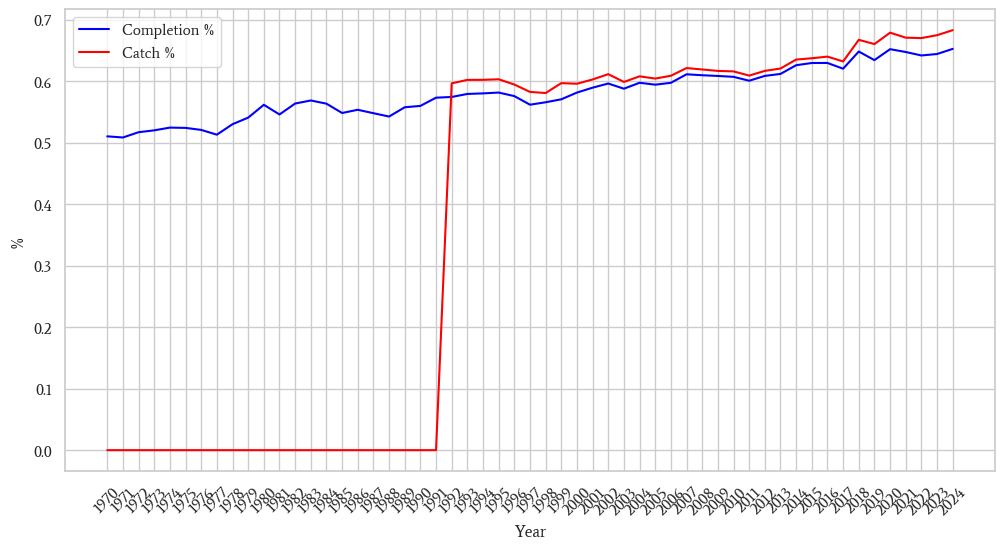

In [5]:
# initialize some lists
catch_rates = []
cmp_rates = []
years = []
diffs = []

# iterate through seasons
for (year, data) in df.groupby('Year'):
    # get catch rate for the season
    total_rec = data['Rec_Rec'].sum()
    total_tgt = data['Rec_Tgt'].sum()
    catch_rate = total_rec / total_tgt if total_tgt > 0 else 0

    # get completion percentage for the season
    total_cmp = data['Pass_Cmp'].sum()
    total_att = data['Pass_Att'].sum()
    cmp_rate = total_cmp / total_att if total_att > 0 else 0

    # calc diff
    diff = catch_rate - cmp_rate

    # append to lists
    catch_rates.append(catch_rate)
    cmp_rates.append(cmp_rate)
    years.append(year)
    diffs.append(diff)

# Plot rates
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years)), years, rotation=45)
plt.plot(cmp_rates, color='blue', label='Completion %')
plt.plot(catch_rates, color='red', label='Catch %')
plt.xlabel('Year')
plt.ylabel('%')
plt.grid(True)
plt.legend()
plt.show()

- Catch rate has steadily rose from 60% to 67% in the last 10-15 years due to the more pass heavy offenses we see today. However, from 1992-2006, catch rates were steadily around __60%__.
- Completion percentage is consistently 1-2% lower than catch rate (due to balls thrown away, blocked passes, and spikes). 
- Let's inspect the differences between catch rate and completion percentage for 1992-2023 so we can fill the nulls confidently.

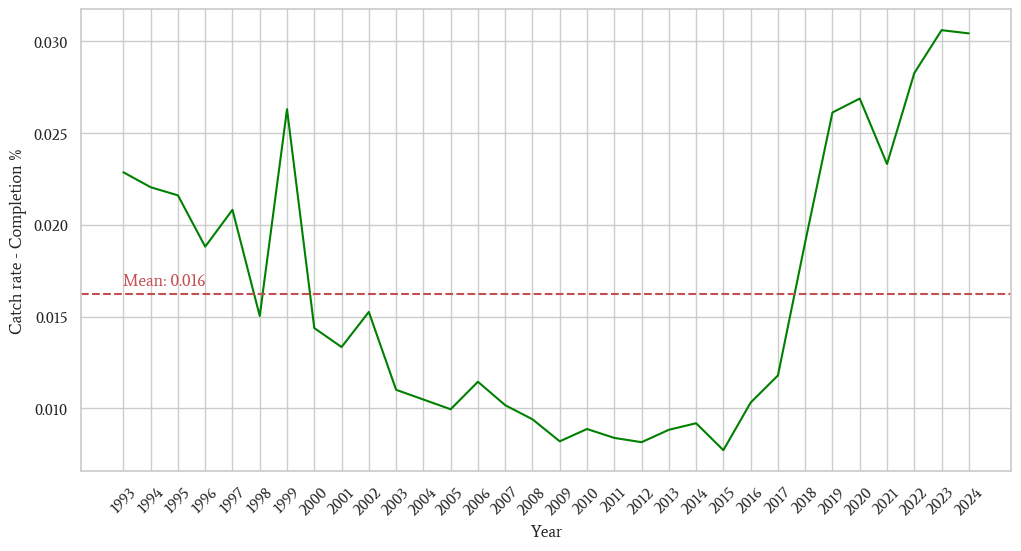

In [6]:
# view diffs
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years[23:])), years[23:], rotation=45)
plt.plot(diffs[23:], color='green')
plt.xlabel('Year')
plt.ylabel('Catch rate - Completion %')
plt.grid(True)

# plot mean
plt.axhline(y=np.mean(diffs[23:]), color='r', linestyle='--')
plt.text(0, np.mean(diffs[23:]) + 0.0005, 'Mean: {:.3f}'.format(np.mean(diffs[23:])), color='r')
plt.show()

- The mean differential is around __1.6%__. I will add this value to the completion percentage for the 1970-1991 seasons to estimate the __catch rate__. 
- We will assume this catch rate for every player with a recorded reception. Then, we can divide each player's receptions by the catch rate to get __total targets__.

In [7]:
# mean of diffs
mean_diff = np.mean(diffs[23:])

# iterate through seasons before 1992
for (year, data) in df.loc[df['Year'] < 1992].groupby('Year'):

    # get completion percentage for the season
    total_cmp = data['Pass_Cmp'].sum()
    total_att = data['Pass_Att'].sum()
    cmp_rate = total_cmp / total_att

    # calculate catch rate
    catch_rate = cmp_rate + mean_diff

    # fill 'Rec_Tgt' column by dividing receptions by catch rate
    df.loc[df['Year'] == year, 'Rec_Tgt'] = df.loc[df['Year'] == year, 'Rec_Rec'] / catch_rate

# fill rest (recievers with 0 receptions) with 0
df['Rec_Tgt'] = df['Rec_Tgt'].fillna(0)

- Since we have fumble data for all years, null Fmb (fumbles) will be filled with 0.
- Prior to 1994 we have no FmbLost. We can estimate this by calculating the average fumbles lost % for each given season.

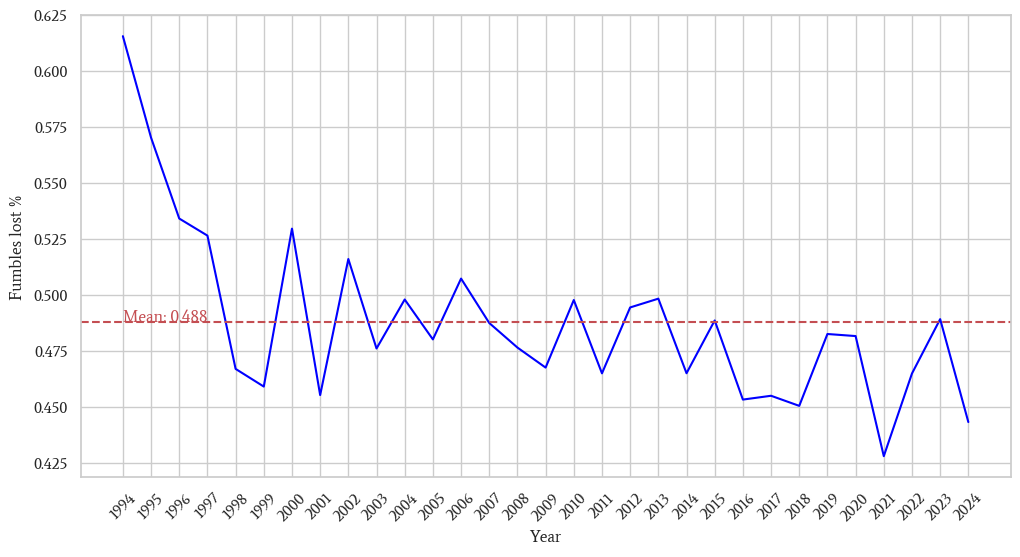

In [8]:
# fill fumbles with 0
df['Fmb'] = df['Fmb'].fillna(0)

# list for plotting
rates = []

# iterate through seasons
for (year, data) in df.loc[df['Year'] >= 1994].groupby('Year'):
    # get fumbles lost % for the season
    total_fmb = data['Fmb'].sum()
    total_fmb_lost = data['FmbLost'].sum()
    fmb_rate = total_fmb_lost / total_fmb

    # append to list
    rates.append(fmb_rate)

# plot rates
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years[24:])), years[24:], rotation=45)
plt.plot(rates, color='blue')
plt.xlabel('Year')
plt.ylabel('Fumbles lost %')
plt.grid(True)

# plot mean
mean_rate = np.mean(rates)
plt.axhline(y=mean_rate, color='r', linestyle='--')
plt.text(0, mean_rate + 0.0005, 'Mean: {:.3f}'.format(mean_rate), color='r')
plt.show()

- We can see that the mean fumbles lost rate is about __49%__ from 1994-2024. 
- Reading the plot right-to-left, it seems to be trending upward past 60% (as if prior seasons lost fumbles at a higher rate). 
- I will use __55%__ as the estimate in order to capture this trend but still not overestimating.

In [9]:
# fumble rate
fumble_rate = 0.55

# iterate through seasons before 1992
for (year, data) in df.loc[df['Year'] < 1994].groupby('Year'):

    # fill 'FmbLost' column by multiplying fumbles by fumble rate (55%)
    df.loc[df['Year'] == year, 'FmbLost'] = df.loc[df['Year'] == year, 'Fmb'] * fumble_rate

# fill rest (players with 0 fumbles) with 0
df['FmbLost'] = df['FmbLost'].fillna(0)

# view nulls once more
df.isnull().sum().sum()

0

- All nulls have been filled.

# Scrimmage Yards, Games Played

In [10]:
# add Scrimmage Yds
df['Scrim_Yds'] = df['Rush_Yds'] + df['Rec_Yds']

# assign default value
df['num_games'] = 0

# assign 16 games for seasons before 2021, 17 games for seasons later
df.loc[df['Year'] < 2021, 'num_games'] = 16
df.loc[df['Year'] >= 2021, 'num_games'] = 17

# use the games played to assess if a player has been injured
df['games_played_pct'] = df['G'] / df['num_games']
df['games_started_pct'] = (df['GS'] / df['G']).fillna(0)

# check
df.head(1)

,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Scrim_TD,Key,Year,Pass_Y/A,Scrim_Yds,num_games,games_played_pct,games_started_pct
0,Ron Johnson*+,NYG,RB,23,14,14,0,0,0,0,0,263,1027,3.904943,8,91.106124,48,487,10.145833,4,5.0,2.75,12,JohnRo02,1970,0.0,1514,16,0.875,1.0


# Pro Bowl, All Pro Selections
The 'Player' column contains the special characters '*' and '+'. These are used to indicate Pro Bowl and All-Pro selections respectively.

In [11]:
# add 'ProBowl' column if '*' in 'Player'
df['ProBowl'] = df['Player'].apply(lambda x: True if '*' in x else False).astype(int)

# add 'AllPro' column if '+' in 'Player'
df['AllPro'] = df['Player'].apply(lambda x: True if '+' in x else False).astype(int)

# remove '*' and '+' from 'Player' column
df['Player'] = df['Player'].apply(lambda x: x.replace('*', '').replace('+', ''))

# Position

In [12]:
# look at unique positions
df['Pos'].unique()

array(['RB', 'WR', 'FB', 'QB', 'TE'], dtype=object)

The 'FB' position values will be replaced with 'RB', as they both occupy the RB position in fantasy lineups.

In [13]:
# replace FB with RB in 'Pos' column
df['Pos'] = df['Pos'].apply(lambda x: 'RB' if x == 'FB' else x)

# Years of Experience

Here we will add a feature '__experience__' to represent the player's years of experience. For example, a rookie player would have exp=0.

First, we need to estimate experience for the 1970 players. Most of these players are not rookies. After manually inspecting the [1970 season](https://www.pro-football-reference.com/years/1970/fantasy.htm) on Pro Football Reference, it seems like the majority of rookies in that season were __22 years old__. This makes sense (4 years of college was standard back then). Thus, we will assume that 1970 players were 22 their rookie season in order to estimate their years of experience.

In [14]:
# create column 'exp' for years of experience
df['Exp'] = np.nan

# default value
rookie_age = 22

# 'exp' for 1970 players will be 'Age' - 22
df.loc[df['Year'] == 1970, 'Exp'] = df.loc[df['Year'] == 1970, 'Age'] - rookie_age

# check
df.query('Year == 1970')[['Player', 'Age', 'Exp']].head()

,Player,Age,Exp
0,Ron Johnson,23,1.0
1,Gene Washington,23,1.0
2,MacArthur Lane,28,6.0
3,Warren Wells,28,6.0
4,John Brodie,35,13.0


In [15]:
# ensure we are sorted by year
df = df.sort_values('Year')

# group by unique player identifier 'Key' and fill experience values
df = df.groupby('Key').apply(fill_experience).reset_index(drop=True)

# Patrick Mahomes
df[df['Player'] == 'Patrick Mahomes'][['Player', 'Year', 'Exp']]

C:\Users\heefj\AppData\Local\Temp\ipykernel_6028\2174682029.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Key').apply(fill_experience).reset_index(drop=True)


,Player,Year,Exp
16421,Patrick Mahomes,2017,0
16422,Patrick Mahomes,2018,1
16423,Patrick Mahomes,2019,2
16424,Patrick Mahomes,2020,3
16425,Patrick Mahomes,2021,4
16426,Patrick Mahomes,2022,5
16427,Patrick Mahomes,2023,6
16428,Patrick Mahomes,2024,7


# Volume and Efficiency
We will add 3 columns:
- __Touches__: sum of Passing, Rushing, and Receiving Attempts (reflects total volume).
- __Completion %__ (Pass Completions / Pass Attempts)
- __Catch Rate__ (Receptions / Targets)

In [16]:
# add 'Touches' column
df['Touches'] = (df['Pass_Att'] + df['Rush_Att'] + df['Rec_Rec']).fillna(0)
df['Pass_Cmp%'] = (df['Pass_Cmp'] / df['Pass_Att']).fillna(0)
df['Rec_Catch%'] = (df['Rec_Rec'] / df['Rec_Tgt']).fillna(0)

# Per-Game Stats
We will also add normalized stats on a per-game basis.

In [17]:
# statistical columns to be normalized
stats_words = ['Pass', 'Rush', 'Rec', 'Fmb', 'Scrim', 'Touches']
stats_cols = [col for col in df.columns if any(word in col for word in stats_words) and col not in ['Pass_Y/A', 'Rush_Y/A', 'Rec_Y/R', 'Pass_Cmp%', 'Rec_Catch%']]

# normalize stats columns (per game)
for col in stats_cols:
    df[col + '_per_game'] = df[col] / df['G']

    # fill nulls with 0
    df[col + '_per_game'] = df[col + '_per_game'].fillna(0)

# __Points__ and __Rankings__
We will add point columns for 4 different formats:
- __Standard__
- __Half-point PPR__
- __PPR__
- __6-point passing TDs__ (Full-point PPR as well)

We will also add __per-game__ and __per-touch__ columns for each of the 4 scoring formats. Both __overall ranks__ and __positional ranks__ will also be added here.

In [18]:
# add point columns to df
points_type = 'half-ppr'
df = add_point_cols(df, points_type)

# add rank columns
df = add_rank_cols(df, points_type)

# check
df.sample()[['Player', 'Year', 'Pos', 'G'] + [col for col in df.columns if points_type in col]]

,Player,Year,Pos,G,Points_half-ppr,PPG_half-ppr,PPT_half-ppr,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr
12291,Austin Hooper,2022,TE,17,76.9,4.523529,1.87561,191,25,257,33,183,58


## Value over Replacement Player
A 12-team league with the Underdog Fantasy roster:
- 1 QB
- 2 RB
- 3 WR
- 1 TE
- 1 FLEX (RB/WR/TE)

Thus, the replacement players are:
- QB12
- RB30 (assuming half the flex spots are RBs)
- WR42 (assuming half the flex spots are WRs)
- TE12

Here, I will also calculate the VORP for 12 team and 3WR leagues.

In [19]:
# add VORP columns
df = add_vorp_cols(df, points_type)

# view top 12 QBs of 2024
df.query('(Year == 2024) & (Pos == "QB")')[['Player', 'Year', 'G'] + [col for col in df.columns if col.startswith(('Points', 'PPG'))]].sort_values('Points_half-ppr', ascending=False).head(12)

,Player,Year,G,Points_half-ppr,PPG_half-ppr,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,Points_VORP_half-ppr,PPG_VORP_half-ppr
13026,Lamar Jackson,2024,17,432.38,25.434118,1,1,1,1,149.98,6.843451
332,Josh Allen,2024,17,383.04,22.531765,2,2,2,2,100.64,3.941098
3514,Joe Burrow,2024,17,381.82,22.460000,3,3,3,3,99.42,3.869333
17060,Baker Mayfield,2024,17,379.80,22.341176,4,4,4,4,97.40,3.750510
5947,Jayden Daniels,2024,17,358.82,21.107059,5,5,6,6,76.42,2.516392
9558,Jared Goff,2024,17,333.96,19.644706,8,6,11,8,51.56,1.054039
19604,Bo Nix,2024,17,328.70,19.335294,10,7,12,9,46.30,0.744627
12713,Jalen Hurts,2024,15,320.12,21.341333,12,8,5,5,37.72,2.750667
5992,Sam Darnold,2024,17,319.96,18.821176,13,9,15,11,37.56,0.230510
19281,Kyler Murray,2024,17,306.24,18.014118,15,10,19,14,23.84,-0.576549


- We can see that Lamar Jackson was the top QB of 2024 (by a good margin).
- Justin Herbert is the replacement level QB at rank #12 (VORP of 0). Jackson's VORP is simply how many more points he scored than Herbert in the 2024 season.

# Target Variable
The target will be the player's fantasy points for the next season.

In [20]:
# add target columns
df = add_target_cols(df, points_type)

# Josh Allen
df.query('Player == "Josh Allen"')[['Player', 'Year', 'Points_half-ppr', 'PPG_half-ppr'] + [col for col in df.columns if 'Target' in col]]

,Player,Year,Points_half-ppr,PPG_half-ppr,PointsTarget_half-ppr,PPGTarget_half-ppr
326,Josh Allen,2018,218.06,18.171667,291.56,18.222500
327,Josh Allen,2019,291.56,18.222500,405.56,25.347500
328,Josh Allen,2020,405.56,25.347500,411.58,24.210588
329,Josh Allen,2021,411.58,24.210588,405.52,25.345000
330,Josh Allen,2022,405.52,25.345000,404.64,23.802353
331,Josh Allen,2023,404.64,23.802353,383.04,22.531765
332,Josh Allen,2024,383.04,22.531765,NaN,NaN


- The target variables for the 2024 season (2025 points) are null, as these haven't happened yet. We will attempt to predict these values in the next notebook.

# PFF Data (2006-2024)
Now, we can add advanced metrics and team-related grades acquired from [Pro Football Focus](https://www.pff.com/).

In [21]:
# drop rows prior to 2006
pff = df[df['Year'] >= 2006].copy()

# pass data
pass_df = load_data('pff/passing/', pff=True)
pass_df = clean_pff_data(pass_df, 'Pass').fillna(0)

# rush data
rush_df = load_data('pff/rushing/', pff=True)
rush_df = clean_pff_data(rush_df, 'Rush').fillna(0)

# rec data
rec_df = load_data('pff/receiving', pff=True)
rec_df = clean_pff_data(rec_df, 'Rec').fillna(0)

# check
for pff_data in [pass_df, rush_df, rec_df]:
    display(pff_data.sample())

,Pass_accuracy_percent,Pass_avg_depth_of_target,Pass_avg_time_to_throw,Pass_grades_hands_fumble,Pass_grades_offense,Pass_grades_pass,Pass_Dropback%,Pass_Aimed_passes%,Pass_Dropped_passes%,Pass_Batted_passes%,Pass_Thrown_away%,Pass_Pressure%,Pass_Scramble%,Pass_Sack%,Pass_Pressure_to_sack%,Pass_BTT%,Pass_TWP%,Pass_First_down%,Player,Year
1842,0.0,25.0,3.2,78.3,60.0,51.2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tyler Boyd,2024


,Rush_elusive_rating,Rush_grades_hands_fumble,Rush_grades_offense,Rush_grades_run,Rush_longest,Rush_Team_Rush%,Rush_Avoided_tackles_per_attempt,Rush_10+_yard_run%,Rush_15+_yard_run%,Rush_15+_yard_run_yards%,Rush_First_down%,Rush_Gap%,Rush_Zone%,Rush_YCO_per_attempt,Player,Year
4707,0.0,30.5,62.8,62.1,2,0.003584,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Gerald Everett,2020


,Rec_avg_depth_of_target,Rec_caught_percent,Rec_contested_catch_rate,Rec_drop_rate,Rec_grades_hands_drop,Rec_grades_hands_fumble,Rec_grades_offense,Rec_grades_pass_route,Rec_inline_rate,Rec_longest,Rec_pass_block_rate,Rec_route_rate,Rec_slot_rate,Rec_targeted_qb_rating,Rec_wide_rate,Rec_yards_after_catch_per_reception,Rec_yards_per_reception,Rec_yprr,Rec_Avoided_tackles_per_reception,Rec_First_down%,Rec_Int_per_target,Rec_YAC%,Player,Year
725,1.1,81.8,0.0,0.0,78.0,71.7,63.3,71.6,0.0,11,20.9,77.6,3.0,89.4,1.5,5.9,6.7,1.15,0.111111,0.333333,0.0,0.883333,Ahmard Hall,2007


In [22]:
# load data
team_df = load_data('pff/team/', pff=True)

# add 'Win%' col
team_df['Win%'] = team_df['Wins'] / (team_df['Wins'] + team_df['Losses'])

# calculate PPG and PPG allowed
team_df['PPG'] = team_df['Points For'] / (team_df['Wins'] + team_df['Losses'])
team_df['PPG_allowed'] = team_df['Points Against'] / (team_df['Wins'] + team_df['Losses'])

# create 'Pass Defense Grade' col as average of 'Pass Rush' and 'Pass Coverage' grades
team_df['Pass Defense Grade'] = ((team_df['Pass Rush Grade'] + team_df['Coverage Grade'])) / 2

# add 'Team' to the beginning of each column name
team_df.columns = ['Team_' + col for col in team_df.columns]

# remove 'Team' from 'Tm' and 'Year'
team_df['Tm'] = team_df['Team_Tm']
team_df['Year'] = team_df['Team_Year']

# drop columns
team_df = team_df.drop(columns=['Team_Tm', 'Team_Year', 'Team_Points For', 'Team_Points Against']).fillna(0)

# check
team_df.sample()

,Team_Team Grade,Team_Offense Grade,Team_Passing Grade,Team_Pass Blocking Grade,Team_Receiving Grade,Team_Rushing Grade,Team_Run Blocking Grade,Team_Defense Grade,Team_Run Defense Grade,Team_Tackling Grade,Team_Pass Rush Grade,Team_Coverage Grade,Team_Special Teams Grade,Team_Wins,Team_Losses,Team_Win%,Team_PPG,Team_PPG_allowed,Team_Pass Defense Grade,Tm,Year
441,85.5,79.7,75.5,81.1,71.0,63.7,88.4,70.7,68.7,47.1,79.2,60.7,77.4,9.0,7.0,0.5625,24.0625,22.125,69.95,PHI,2019


In [23]:
def consolidate_pos_based_column(df, base_col_name):
    """
    Consolidate duplicate columns like 'Pass_X', 'Rush_X', 'Rec_X' into a single column
    based on player position.

    Args:
    - df (pd.DataFrame): your dataframe
    - base_col_name (str): e.g. 'grades_offense' or 'grades_hands_fumble'

    Returns:
    - df (pd.DataFrame): dataframe with the new consolidated column and dropped duplicates
    """

    # get column names
    pass_col, rush_col, rec_col = f'Pass_{base_col_name}', f'Rush_{base_col_name}', f'Rec_{base_col_name}'

    # map positional conditions to the correct column 
    conditions = [df['Pos'] == 'QB', df['Pos'] == 'RB', df['Pos'].isin(['WR', 'TE'])]
    choices = [df[pass_col], df[rush_col], df[rec_col]]
    df['grades_offense'] = np.select(conditions, choices, default=np.nan)

    # drop the original columns
    return df.drop([pass_col, rush_col, rec_col], axis=1)

In [24]:
# iterate through the player data
for pff_data in [pass_df, rush_df, rec_df]:
    # merge with df
    pff = pff.merge(pff_data, on=['Player', 'Year'], how='left')

# handle duplicate 'grades_offense' columns
pff = consolidate_pos_based_column(pff, 'grades_offense')
pff = consolidate_pos_based_column(pff, 'grades_hands_fumble')

# merge team data
pff = pff.merge(team_df, on=['Tm', 'Year'], how='left')

# target columns
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in pff.columns if col not in target_cols]

# fill all nulls with 0 except for the target columns
pff[non_target_cols] = pff[non_target_cols].fillna(0)

# check
pff.sample()

,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,Scrim_TD,Key,Year,Pass_Y/A,Scrim_Yds,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,Touches,Pass_Cmp%,Rec_Catch%,Pass_Cmp_per_game,Pass_Att_per_game,Pass_Yds_per_game,Pass_TD_per_game,Pass_Int_per_game,Rush_Att_per_game,Rush_Yds_per_game,Rush_TD_per_game,Rec_Tgt_per_game,Rec_Rec_per_game,Rec_Yds_per_game,Rec_TD_per_game,Fmb_per_game,FmbLost_per_game,Scrim_TD_per_game,Scrim_Yds_per_game,Touches_per_game,Points_half-ppr,PPG_half-ppr,PPT_half-ppr,PointsOvrRank_half-ppr,PointsPosRank_half-ppr,PPGOvrRank_half-ppr,PPGPosRank_half-ppr,PPTOvrRank_half-ppr,PPTPosRank_half-ppr,Points_VORP_half-ppr,PPG_VORP_half-ppr,PointsTarget_half-ppr,PPGTarget_half-ppr,Pass_accuracy_percent,Pass_avg_depth_of_target,Pass_avg_time_to_throw,Pass_grades_pass,Pass_Dropback%,Pass_Aimed_passes%,Pass_Dropped_passes%,Pass_Batted_passes%,Pass_Thrown_away%,Pass_Pressure%,Pass_Scramble%,Pass_Sack%,Pass_Pressure_to_sack%,Pass_BTT%,Pass_TWP%,Pass_First_down%,Rush_elusive_rating,Rush_grades_run,Rush_longest,Rush_Team_Rush%,Rush_Avoided_tackles_per_attempt,Rush_10+_yard_run%,Rush_15+_yard_run%,Rush_15+_yard_run_yards%,Rush_First_down%,Rush_Gap%,Rush_Zone%,Rush_YCO_per_attempt,Rec_avg_depth_of_target,Rec_caught_percent,Rec_contested_catch_rate,Rec_drop_rate,Rec_grades_hands_drop,Rec_grades_pass_route,Rec_inline_rate,Rec_longest,Rec_pass_block_rate,Rec_route_rate,Rec_slot_rate,Rec_targeted_qb_rating,Rec_wide_rate,Rec_yards_after_catch_per_reception,Rec_yards_per_reception,Rec_yprr,Rec_Avoided_tackles_per_reception,Rec_First_down%,Rec_Int_per_target,Rec_YAC%,grades_offense,Team_Team Grade,Team_Offense Grade,Team_Passing Grade,Team_Pass Blocking Grade,Team_Receiving Grade,Team_Rushing Grade,Team_Run Blocking Grade,Team_Defense Grade,Team_Run Defense Grade,Team_Tackling Grade,Team_Pass Rush Grade,Team_Coverage Grade,Team_Special Teams Grade,Team_Wins,Team_Losses,Team_Win%,Team_PPG,Team_PPG_allowed,Team_Pass Defense Grade
9205,David Sills,DEN,WR,27,3,1,0,0,0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,0,SillDa01,2023,0.0,0,17,0.176471,0.333333,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,534,204,534,204,534,204,-165.7,-10.441176,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9,74.6,71.0,72.7,69.6,77.6,72.3,60.0,59.3,34.2,69.8,48.4,83.9,8.0,9.0,0.470588,21.0,24.294118,59.1


# Save Data

In [25]:
# fill infinities
df = df.replace([np.inf, -np.inf], 0)
pff = pff.replace([np.inf, -np.inf], 0)

# ensure values are sorted properly
df = df.sort_values(by=['Key', 'Exp']).reset_index(drop=True)
pff = pff.sort_values(by=['Key', 'Exp']).reset_index(drop=True)

# save data
df.to_csv('./data/clean/fantasy_data.csv', index=False)
pff.to_csv('./data/clean/pff_fantasy_data.csv', index=False)